# Assignment 2: Vector Space Semantics for Similarity between Eastenders Characters (Part 1)

<p>
Name: Eleanor Prashamshini <br>
Student ID: 220772291 <br>
Subject: Natural Language Processing (ECS763P) <br>
</p>

## Description

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

## 0. Setup and Loading Data

In [1]:
!pip install nltk

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

%matplotlib inline
pd.options.display.max_colwidth=500

In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [4]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [5]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [6]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [7]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [8]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [9]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


## 1. Improve Pre-processing

Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of **0.25** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.

In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

In [11]:
stop_words = [w.lower() for w in stopwords.words('english')] # getting stop-words from nltk.corpus

In [12]:
def pre_process_test_q1(character_text, methods='bow,re,swr,lm'):
    """Pre-process testing for all the concatenated lines of a character, 
    using tokenization, stop word removal, EOL removal and lemmatization.
    
    ::character_text:: a string with all of one character's lines
    ::methods:: the pre-processing methods combination
    """
    
    lemmatizer = WordNetLemmatizer() # using lemmatizer from nltk.stem 
    eol = "_eol_"
    
    tokens = []
    
    character_text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) # separates punctuation at ends of strings
    character_text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", character_text) # separates punctuation at beginning 
    
    # baseline - a simple tokenization
    if methods == 'b':
        tokens = character_text.split()
    # bag of words - lowercased and punctuations removed
    elif methods == 'bow':
        tokens = [t.lower() for t in word_tokenize(character_text) 
                  if t.strip(string.punctuation) != ""]
    # bow, EOL removed
    elif methods == 'bow,re':
        tokens = [t.lower() for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() != eol)]
    # bow, stop words removed
    elif methods == 'bow,swr':
        tokens = [t.lower() for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words)]
    # bow, EOL removed, stop words removed
    elif methods == 'bow,re,swr':
        tokens = [t.lower() for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words and t.lower() != eol)]
    # bow, stop words removed, lemmatization
    elif methods == 'bow,swr,lm':
        tokens = [lemmatizer.lemmatize(t.lower()) for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words)]
    # bow, EOL removed, stop words removed, lemmatization
    elif methods == 'bow,re,swr,lm':
        tokens = [lemmatizer.lemmatize(t.lower()) for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words and t.lower() != eol)]
    # best selected pre-processing in Q1 - bow,re,swr,lm
    else:
        tokens = [lemmatizer.lemmatize(t.lower()) for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words and t.lower() != eol)]
    
    # Output: bag of words as list
    return tokens

## 2. Improve Linguistic Feature Extraction

Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [13]:
def get_wordnet_pos(treebank_tag):
    """Converts from Part-of-Speech tag to wordnet tag
    
    ::treebank_tag:: POS tag from penn treebank
    """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [14]:
def pre_process_test_q2(character_text, methods='u'):
    """Pre-process testing for all the concatenated lines of a character, 
    using part-of-speech tags and ngrams.
    
    ::character_text:: a string with all of one character's lines
    ::methods:: the pre-processing methods combination
    """
    
    lemmatizer = WordNetLemmatizer() # using lemmatizer from nltk.stem 
    eol = "_eol_"
    
    tokens = []
    
    character_text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) # separates punctuation at ends of strings
    character_text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", character_text) # separates punctuation at beginning 
    
    # bag of words - keeping the stop words and using _EOL_ to differentiate between sentences
    bow = [t.lower() for t in word_tokenize(character_text) 
           if t.strip(string.punctuation) != ""]
    bow_pos = []
    
    # baseline - unigrams
    if methods == 'u':
        # unigrams
        tokens = [lemmatizer.lemmatize(t.lower()) for t in word_tokenize(character_text) 
                  if (t.strip(string.punctuation) != "" and t.lower() not in stop_words and t.lower() != eol)]
    
    elif methods == 'pos+u':
        # unigrams
        for w, tag in nltk.pos_tag(bow):
            if w not in stop_words and w != eol:
                if get_wordnet_pos(tag) != '':
                    tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
                else:
                    tokens.append(lemmatizer.lemmatize(w))
    
    # unigrams, bigrams
    elif methods == 'pos+u,bi':
        # unigrams
        for w, tag in nltk.pos_tag(bow):
            if w not in stop_words and w != eol:
                if get_wordnet_pos(tag) != '':
                    tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
                else:
                    tokens.append(lemmatizer.lemmatize(w))
        # bigrams
        for t1, t2 in list(ngrams(bow, 2)):
            if eol not in [t1, t2]:
                tokens.append(lemmatizer.lemmatize(t1)+" "+lemmatizer.lemmatize(t2))
    
    # unigrams, trigrams
    elif methods == 'pos+u,tri':
        # unigrams
        for w, tag in nltk.pos_tag(bow):
            if w not in stop_words and w != eol:
                if get_wordnet_pos(tag) != '':
                    tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
                else:
                    tokens.append(lemmatizer.lemmatize(w))

        # trigrams
        for t1, t2, t3 in list(ngrams(bow, 3)):
            if eol not in [t1, t2, t3]:
                tokens.append(lemmatizer.lemmatize(t1)+" "+lemmatizer.lemmatize(t2)+" "+lemmatizer.lemmatize(t3))
    
    # unigrams, bigrams, trigrams
    elif methods == 'pos+u,bi,tri':
        for w, tag in nltk.pos_tag(bow):
            if w not in stop_words and w != eol:
                if get_wordnet_pos(tag) != '':
                    tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
                else:
                    tokens.append(lemmatizer.lemmatize(w))

        # bigrams
        for t1, t2 in list(ngrams(bow, 2)):
            if eol not in [t1, t2]:
                tokens.append(lemmatizer.lemmatize(t1)+" "+lemmatizer.lemmatize(t2))

        # trigrams
        for t1, t2, t3 in list(ngrams(bow, 3)):
            if eol not in [t1, t2, t3]:
                tokens.append(lemmatizer.lemmatize(t1)+" "+lemmatizer.lemmatize(t2)+" "+lemmatizer.lemmatize(t3))
    
    # best selected pre-processing in Q2 - pos+u
    else:
        for w, tag in nltk.pos_tag(bow):
            if w not in stop_words and w != eol:
                if get_wordnet_pos(tag) != '':
                    tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
                else:
                    tokens.append(lemmatizer.lemmatize(w))
    
    # Output: bag of words as list
    return tokens

In [15]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    lemmatizer = WordNetLemmatizer() # using lemmatizer from nltk.stem 
    eol = "_eol_"
    tokens = []
    
    # separating punctuations
    character_text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) # ends of words
    character_text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", character_text) # beginning of words 
    
    # bag of words - keeping the stop words and using _EOL_ to differentiate between sentences
    bow = [t.lower() for t in word_tokenize(character_text) 
              if t.strip(string.punctuation) != ""]
    
    # unigrams
    for w, tag in nltk.pos_tag(bow):
        if w not in stop_words and w != eol:
            if get_wordnet_pos(tag) != '':
                tokens.append(lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
            else:
                tokens.append(lemmatizer.lemmatize(w))
                
    return tokens

In [16]:
def additional_features(character_text):
    """Creates new features - sentiment analysis
    
    ::character_text:: character lines as a striing
    """
    
    extra_tokens = []
    
    # sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(character_text)
    if sentiment['pos'] > sentiment['neg'] and sentiment['pos'] > sentiment['neu']:
        extra_tokens.append('sentiment_positive')
    elif sentiment['neg'] > sentiment['pos'] and sentiment['neg'] > sentiment['neu']:
        extra_tokens.append('sentiment_negative')
    else:
        extra_tokens.append('sentiment_neutral')
    
    return extra_tokens

In [17]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc), additional_features(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc, extra_features in training_corpus]

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens associated with their counts
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    counts = Counter(character_doc + extra_features)  # for now a simple count
    counts = dict(counts)
    
    return counts  

In [19]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

np.seterr(divide='ignore', invalid='ignore') # used for ignoring divide by zero 

# selector picks 33 percentile of features that contribute most towards the label
selector = SelectPercentile(mutual_info_classif, percentile=33)

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, extra_features) for name, doc, extra_features in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, extra_features) for name, doc, extra_features in corpus]) 
    
    if fitting:
        doc_labels = [name for name, doc, extra_features in corpus]
        selector.fit(doc_feature_matrix, doc_labels)
    select_feature_matrix = selector.transform(doc_feature_matrix.toarray())
    
    #training_feature_matrix[0].toarray()
    return select_feature_matrix 

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [20]:
training_feature_matrix.shape

(16, 1119)

In [21]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc), additional_features(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc, extra_features in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [22]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [23]:
val_feature_matrix.shape

(16, 1119)

## 3. Analyse the Similarity Results

From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

In [24]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [25]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    print("Failing targets and ranking:")
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        else:
            print(target, ranking[target])
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("\n***** RESULTS *****")
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [26]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [27]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

Failing targets and ranking:
CLARE 2
JACK 3
SEAN 5
SHIRLEY 5

***** RESULTS *****
mean rank 1.6875
mean cosine similarity 0.6432594354628829
12 correct out of 16 / accuracy: 0.75


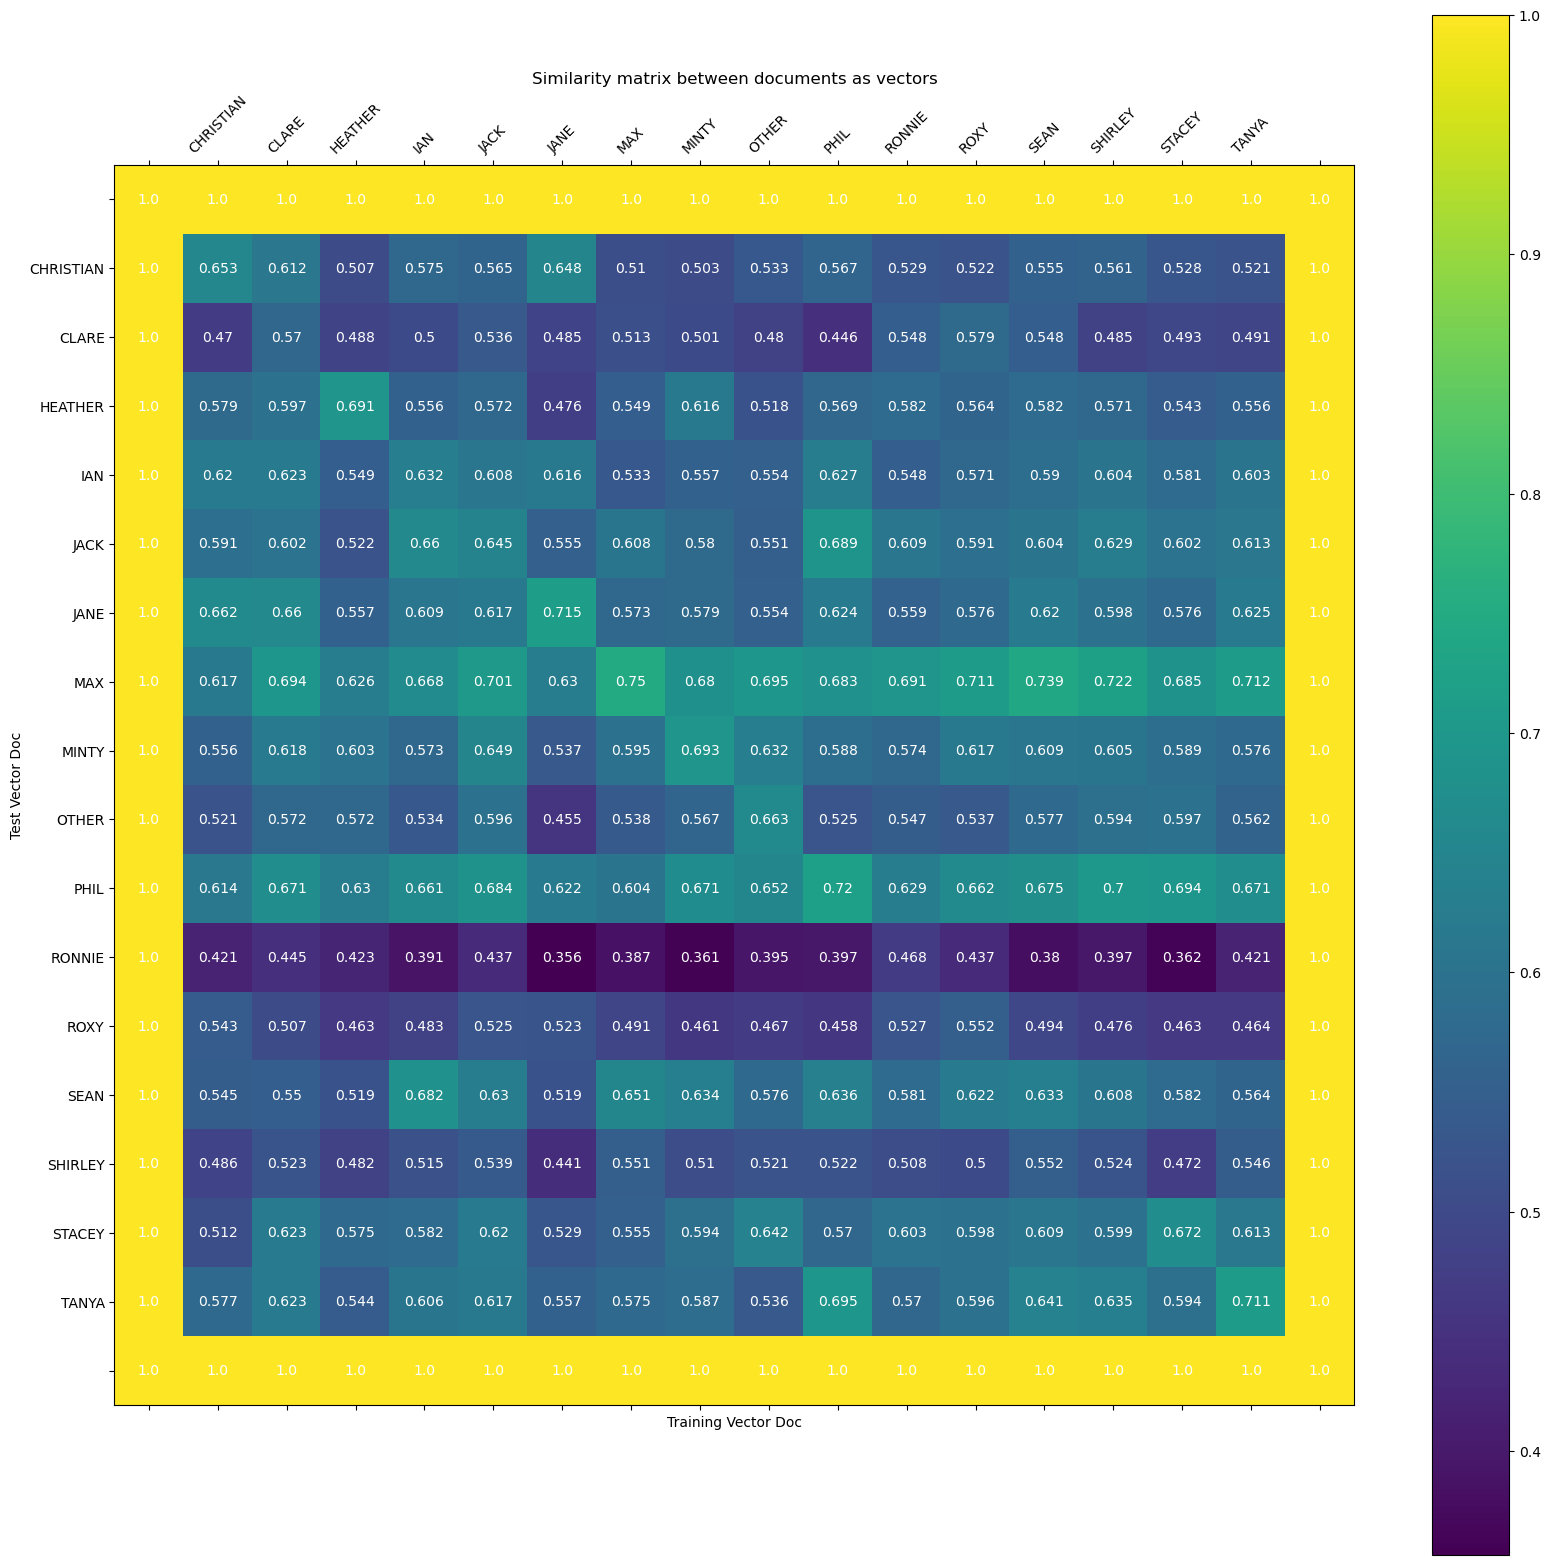

In [28]:
plot_heat_map_similarity(df)

## 4. Add Dialogue Context and Scene Features (Part 2)

Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. You can also use **scene_info** column to extract information about the scene **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

## 5. Improve the Vectorization Method (Part 2)

Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

## 6. Run on Final Test Data (Part 2)

Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [29]:
# Set to False, to avoid peaking at test and ensure generalisation
if False:
    # redo on all training data with the first 400 character lines used
    train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
    print('Num. Characters: ',len(train_character_docs.keys()),"\n")
    total_words = 0
    for name in train_character_docs.keys():
        print(name, 'Number of Words: ',len(train_character_docs[name].split()))
        total_words += len(train_character_docs[name].split())
    print("total words", total_words)

    training_corpus = [(name, pre_process(doc), additional_features(doc)) for name, doc in train_character_docs.items()]
    train_labels = [name for name, doc, extra_features in training_corpus]

    corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
    # Any matrix transformers (e.g. tf-idf transformers) should be initialized here

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
    
    # get the test data using 40 lines per character
    test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
    print('Num. Characters: ',len(test_character_docs.keys()),"\n")
    total_words = 0
    for name in test_character_docs.keys():
        print(name, 'Number of Words: ',len(test_character_docs[name].split()))
        total_words += len(test_character_docs[name].split())
    print("total words", total_words)

    # create list of pairs of (character name, pre-processed character) 
    test_corpus = [(name, pre_process(doc), additional_features(doc)) for name, doc in test_character_docs.items()]
    test_labels = [name for name, doc, extra_features in test_corpus]


    # Just transform the val_feature_matrix, don't fit
    test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)
    
    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)